In [1]:
pip install "protobuf==3.20.3"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 6.4 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

In [2]:
import random, time, warnings
from dataclasses import dataclass
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image
# from tqdm import tqdm
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from transformers import CLIPProcessor, CLIPModel
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity

warnings.filterwarnings("ignore")
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

@dataclass
class Config:
    data_dir: str = "/kaggle/input/fashion-product-text-images-dataset/data"
    csv_path: str = "/kaggle/input/fashion-product-text-images-dataset/data.csv"
    clip_model_name: str = "openai/clip-vit-base-patch32"
    clip_max_text_len: int = 77

    batch_size: int = 64
    num_workers: int = 2

    # Fine-tune (phương án B)
    lr_clip: float = 1e-5
    weight_decay: float = 0.01
    num_epochs: int = 56
    patience: int = 21
    grad_clip_norm: float = 1.0

    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    seed: int = 42

config = Config()

def set_seed(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(config.seed)

print("Device:", config.device)
print("Batch size:", config.batch_size)


2025-12-12 15:17:15.868579: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765552636.030886      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765552636.080180      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Device: cuda
Batch size: 64


Shape: (44441, 4)
image             0
description     281
display_name      7
category          0
dtype: int64


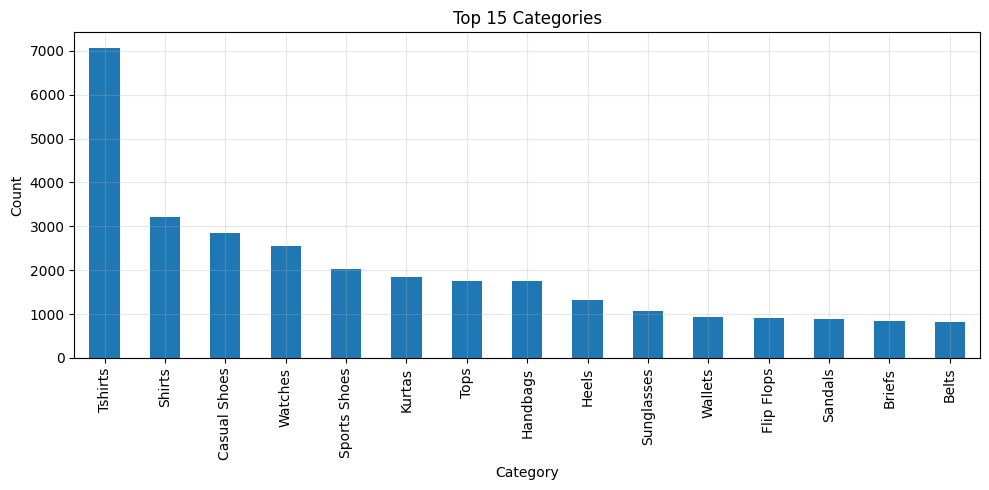

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

Tokenizing sample texts for stats:   0%|          | 0/5000 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (179 > 77). Running this sequence through the model will result in indexing errors



CLIP token length stats (sample):
mean: 123.358 p50: 133.0 p90: 198.0 p95: 219.0
%% > 77 tokens: 70.76


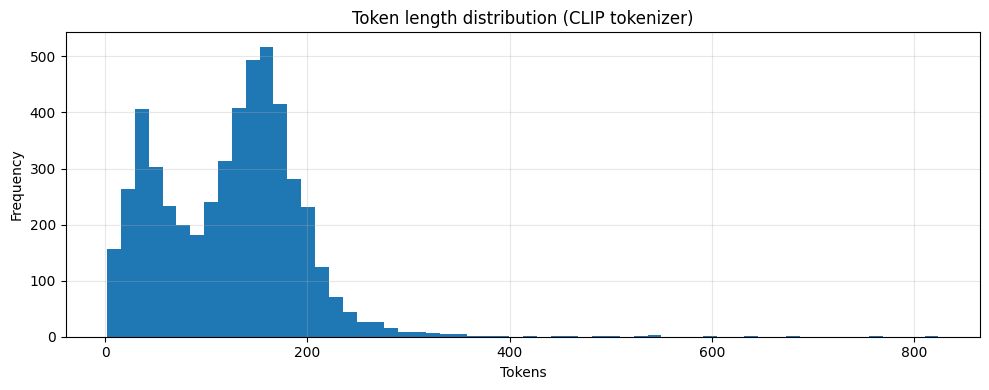

In [3]:
df = pd.read_csv(config.csv_path)
df.columns = df.columns.str.strip().str.replace(" ", "_")

# đảm bảo đủ 4 cột quan trọng
required_cols = ["image", "description", "display_name", "category"]
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

print("Shape:", df.shape)
print(df[required_cols].isna().sum())

# gộp text, fillna để tránh lỗi
df["description"] = df["description"].fillna("")
df["display_name"] = df["display_name"].fillna("")
df["text"] = (df["display_name"].astype(str) + " " + df["description"].astype(str)).str.strip()

# Basic category distribution
top_cats = df["category"].value_counts().head(15)
plt.figure(figsize=(10,5))
top_cats.plot(kind="bar")
plt.title("Top 15 Categories")
plt.xlabel("Category")
plt.ylabel("Count")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# CLIP token length stats (để xem 77 token có bị cắt nhiều không)
processor = CLIPProcessor.from_pretrained(config.clip_model_name)

sample_texts = df["text"].sample(min(5000, len(df)), random_state=config.seed).tolist()
tok_lens = []
for t in tqdm(sample_texts, desc="Tokenizing sample texts for stats"):
    # tokenizer của CLIP nằm trong processor
    enc = processor.tokenizer(
        t, truncation=False, padding=False, return_attention_mask=False
    )
    tok_lens.append(len(enc["input_ids"]))

tok_lens = np.array(tok_lens)
print("\nCLIP token length stats (sample):")
print("mean:", tok_lens.mean(), "p50:", np.percentile(tok_lens,50), "p90:", np.percentile(tok_lens,90), "p95:", np.percentile(tok_lens,95))
print("%% > 77 tokens:", (tok_lens > config.clip_max_text_len).mean() * 100)

plt.figure(figsize=(10,4))
plt.hist(tok_lens, bins=60)
plt.title("Token length distribution (CLIP tokenizer)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [4]:
class CLIPFashionDataset(Dataset):
    def __init__(self, df: pd.DataFrame, data_dir: str, processor: CLIPProcessor, config: Config):
        self.df = df.reset_index(drop=True).copy()
        self.data_dir = data_dir
        self.processor = processor
        self.config = config

        # giữ row_id để trace lại item
        self.df["_row_id"] = np.arange(len(self.df))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.data_dir, row["image"])

        try:
            image = Image.open(img_path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224), color="white")

        text = row["text"]

        inputs = self.processor(
            text=text,
            images=image,
            padding="max_length",
            truncation=True,
            max_length=self.config.clip_max_text_len,
            return_tensors="pt"
        )

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),    # (3,H,W)
            "input_ids": inputs["input_ids"].squeeze(0),          # (L)
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "category": row["category"],
            "row_id": int(row["_row_id"]),
        }

MIN_SAMPLES_PER_CAT = 5  # gộp rare trên toàn dataset trước khi split

cat_counts = df["category"].value_counts()
rare_cats = cat_counts[cat_counts < MIN_SAMPLES_PER_CAT].index
df_fixed = df.copy()
df_fixed.loc[df_fixed["category"].isin(rare_cats), "category"] = "Other"

print(f"Rare categories merged into 'Other' (<{MIN_SAMPLES_PER_CAT}):", len(rare_cats))
print("Top categories after global merge:")
print(df_fixed["category"].value_counts().head(10))


class CLIPDataModule:
    def __init__(self, config: Config, processor: CLIPProcessor):
        self.config = config
        self.processor = processor

    def setup(self, df: pd.DataFrame):
        # ---- Split 1: train vs temp ----
        train_df, temp_df = train_test_split(
            df,
            test_size=0.30,
            random_state=self.config.seed,
            stratify=df["category"]
        )

        # ---- SAFETY: ensure temp_df has no class with <2 samples for stratify ----
        temp_counts = temp_df["category"].value_counts()
        temp_rare = temp_counts[temp_counts < 2].index

        if len(temp_rare) > 0:
            print("Temp split still has categories with <2 samples. Merging into 'Other':", len(temp_rare))
            temp_df = temp_df.copy()
            temp_df.loc[temp_df["category"].isin(temp_rare), "category"] = "Other"

        # ---- Split 2: val vs test ----
        val_df, test_df = train_test_split(
            temp_df,
            test_size=0.50,
            random_state=self.config.seed,
            stratify=temp_df["category"]
        )

        self.train_dataset = CLIPFashionDataset(train_df, self.config.data_dir, self.processor, self.config)
        self.val_dataset   = CLIPFashionDataset(val_df,   self.config.data_dir, self.processor, self.config)
        self.test_dataset  = CLIPFashionDataset(test_df,  self.config.data_dir, self.processor, self.config)

    def get_dataloaders(self):
        train_loader = DataLoader(
            self.train_dataset, batch_size=self.config.batch_size,
            shuffle=True, num_workers=self.config.num_workers, pin_memory=True
        )
        val_loader = DataLoader(
            self.val_dataset, batch_size=self.config.batch_size,
            shuffle=False, num_workers=self.config.num_workers, pin_memory=True
        )
        test_loader = DataLoader(
            self.test_dataset, batch_size=self.config.batch_size,
            shuffle=False, num_workers=self.config.num_workers, pin_memory=True
        )
        return train_loader, val_loader, test_loader


# RUN
dm = CLIPDataModule(config, processor)
dm.setup(df_fixed)
train_loader, val_loader, test_loader = dm.get_dataloaders()

print("Train/Val/Test sizes:", len(dm.train_dataset), len(dm.val_dataset), len(dm.test_dataset))
print("Val category min count:", dm.val_dataset.df["category"].value_counts().min())
print("Test category min count:", dm.test_dataset.df["category"].value_counts().min())


Rare categories merged into 'Other' (<5): 19
Top categories after global merge:
category
Tshirts         7069
Shirts          3215
Casual Shoes    2846
Watches         2542
Sports Shoes    2036
Kurtas          1844
Tops            1762
Handbags        1759
Heels           1323
Sunglasses      1073
Name: count, dtype: int64
Temp split still has categories with <2 samples. Merging into 'Other': 3
Train/Val/Test sizes: 31108 6666 6667
Val category min count: 1
Test category min count: 1


In [5]:
class CLIPTwoTower(nn.Module):
    def __init__(self, config: Config):
        super().__init__()
        self.clip = CLIPModel.from_pretrained(config.clip_model_name)

    def forward(self, pixel_values, input_ids, attention_mask):
        out = self.clip(
            pixel_values=pixel_values,
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        img_emb = F.normalize(out.image_embeds, p=2, dim=-1)  # (B, 512)
        txt_emb = F.normalize(out.text_embeds,  p=2, dim=-1)  # (B, 512)
        logit_scale = self.clip.logit_scale  # learnable
        return img_emb, txt_emb, logit_scale

class CLIPContrastiveLoss(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, img_emb, txt_emb, logit_scale):
        scale = logit_scale.exp()
        logits_i2t = scale * (img_emb @ txt_emb.t())  # (B,B)
        logits_t2i = logits_i2t.t()

        labels = torch.arange(img_emb.size(0), device=img_emb.device)
        loss_i = F.cross_entropy(logits_i2t, labels)
        loss_t = F.cross_entropy(logits_t2i, labels)
        return (loss_i + loss_t) / 2

model = CLIPTwoTower(config).to(config.device)
criterion = CLIPContrastiveLoss()


pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [6]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, config: Config):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.config = config

        self.criterion = CLIPContrastiveLoss()

        self.optimizer = torch.optim.AdamW(
            self.model.parameters(),
            lr=self.config.lr_clip,
            weight_decay=self.config.weight_decay
        )
        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            self.optimizer, T_max=self.config.num_epochs
        )

        self.best_val = float("inf")
        self.patience_counter = 0
        self.train_losses = []
        self.val_losses = []

    def train_epoch(self):
        self.model.train()
        total = 0.0
    
        pbar = tqdm(
            self.train_loader,
            desc="Training",
            leave=True
        )
    
        for step, batch in enumerate(pbar):
            pixel_values = batch["pixel_values"].to(self.config.device)
            input_ids = batch["input_ids"].to(self.config.device)
            attention_mask = batch["attention_mask"].to(self.config.device)
    
            self.optimizer.zero_grad(set_to_none=True)
    
            img_emb, txt_emb, logit_scale = self.model(
                pixel_values, input_ids, attention_mask
            )
            loss = self.criterion(img_emb, txt_emb, logit_scale)
    
            loss.backward()
            torch.nn.utils.clip_grad_norm_(
                self.model.parameters(), self.config.grad_clip_norm
            )
            self.optimizer.step()
    
            total += loss.item()
    
            # 👉 CHỈ update mỗi 20 batch
            if step % 20 == 0:
                pbar.set_postfix_str(
                    f"loss={loss.item():.4f} | scale={logit_scale.exp().item():.1f}"
                )
    
        return total / len(self.train_loader)


    @torch.no_grad()
    def validate(self):
        self.model.eval()
        total = 0.0
        for batch in tqdm(self.val_loader, desc="Validation"):
            pixel_values = batch["pixel_values"].to(self.config.device)
            input_ids = batch["input_ids"].to(self.config.device)
            attention_mask = batch["attention_mask"].to(self.config.device)

            img_emb, txt_emb, logit_scale = self.model(pixel_values, input_ids, attention_mask)
            loss = self.criterion(img_emb, txt_emb, logit_scale)
            total += loss.item()
        return total / len(self.val_loader)

    def fit(self, save_path="CLIP_Finetune_best.pth"):
        start = time.time()
        for epoch in range(self.config.num_epochs):
            tr = self.train_epoch()
            va = self.validate()

            self.train_losses.append(tr)
            self.val_losses.append(va)
            print(f"Epoch {epoch+1}/{self.config.num_epochs} | Train {tr:.6f} | Val {va:.6f}")

            if va < self.best_val:
                self.best_val = va
                self.patience_counter = 0
                torch.save(self.model.state_dict(), save_path)
                print("  Saved best model.")
            else:
                self.patience_counter += 1

            if self.patience_counter >= self.config.patience:
                print("Early stopping.")
                break

            self.scheduler.step()

        print("Training done. Time:", round(time.time()-start, 1), "sec")
        return save_path

trainer = Trainer(model, train_loader, val_loader, config)


model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [7]:
best_ckpt = trainer.fit(save_path="CLIP_Finetune_best.pth")

# load best
model.load_state_dict(torch.load(best_ckpt, map_location=config.device))
model.eval()
print("Loaded best checkpoint:", best_ckpt)


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 1/56 | Train 0.286577 | Val 0.211694
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 2/56 | Train 0.156506 | Val 0.189821
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 3/56 | Train 0.120323 | Val 0.208293


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 4/56 | Train 0.096296 | Val 0.185690
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 5/56 | Train 0.085429 | Val 0.169493
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 6/56 | Train 0.075441 | Val 0.166340
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 7/56 | Train 0.066484 | Val 0.160221
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 8/56 | Train 0.062718 | Val 0.164100


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 9/56 | Train 0.056189 | Val 0.182159


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 10/56 | Train 0.054404 | Val 0.165225


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 11/56 | Train 0.049995 | Val 0.160757


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 12/56 | Train 0.046194 | Val 0.174663


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 13/56 | Train 0.041922 | Val 0.159292
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 14/56 | Train 0.040193 | Val 0.147763
  Saved best model.


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 15/56 | Train 0.040207 | Val 0.164040


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 16/56 | Train 0.037100 | Val 0.161331


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 17/56 | Train 0.035362 | Val 0.162923


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 18/56 | Train 0.032967 | Val 0.165288


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 19/56 | Train 0.032266 | Val 0.159318


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 20/56 | Train 0.028815 | Val 0.162356


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 21/56 | Train 0.027034 | Val 0.170142


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 22/56 | Train 0.027961 | Val 0.150709


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 23/56 | Train 0.025427 | Val 0.169479


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 24/56 | Train 0.021425 | Val 0.172058


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 25/56 | Train 0.022951 | Val 0.165912


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 26/56 | Train 0.022395 | Val 0.163423


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 27/56 | Train 0.019158 | Val 0.157419


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 28/56 | Train 0.020069 | Val 0.170253


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 29/56 | Train 0.017436 | Val 0.179661


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 30/56 | Train 0.017985 | Val 0.178412


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 31/56 | Train 0.015963 | Val 0.168807


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 32/56 | Train 0.015984 | Val 0.166257


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 33/56 | Train 0.014147 | Val 0.168620


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 34/56 | Train 0.013208 | Val 0.162571


Training:   0%|          | 0/487 [00:00<?, ?it/s]

Validation:   0%|          | 0/105 [00:00<?, ?it/s]

Epoch 35/56 | Train 0.012916 | Val 0.173553
Early stopping.
Training done. Time: 22618.4 sec
Loaded best checkpoint: CLIP_Finetune_best.pth


In [8]:
def recall_at_k(sim, categories, k_list=[1,5,10]):
    cats = np.array(categories)
    n = sim.shape[0]
    results = {}

    # diagonal already should be -inf to avoid self-match
    for k in k_list:
        hit = 0
        for i in range(n):
            topk = np.argsort(sim[i])[-k:][::-1]
            if np.any(cats[topk] == cats[i]):
                hit += 1
        results[f"Recall@{k}"] = hit / n
    return results

def mrr(sim, categories):
    cats = np.array(categories)
    n = sim.shape[0]
    rr = []
    for i in range(n):
        order = np.argsort(sim[i])[::-1]
        found = 0.0
        for r, j in enumerate(order, start=1):
            if cats[j] == cats[i]:
                found = 1.0 / r
                break
        rr.append(found)
    return float(np.mean(rr))

def ndcg_at_k(sim, categories, k=10):
    cats = np.array(categories)
    n = sim.shape[0]
    scores = []
    for i in range(n):
        order = np.argsort(sim[i])[::-1][:k]
        rel = (cats[order] == cats[i]).astype(np.int32)

        dcg = 0.0
        for idx, r in enumerate(rel, start=1):
            dcg += r / np.log2(idx + 1)

        # ideal: all relevant = 1 (tối đa k)
        idcg = 0.0
        for idx in range(1, k+1):
            idcg += 1.0 / np.log2(idx + 1)

        scores.append(dcg / idcg if idcg > 0 else 0.0)
    return float(np.mean(scores))

@torch.no_grad()
def extract_item_embeddings(model, loader, device):
    model.eval()
    embs = []
    cats = []
    for batch in tqdm(loader, desc="Extract embeddings"):
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        img_emb, txt_emb, _ = model(pixel_values, input_ids, attention_mask)
        item_emb = F.normalize((img_emb + txt_emb) / 2, p=2, dim=-1)  # late fusion

        embs.append(item_emb.cpu().numpy())
        cats.extend(batch["category"])
    return np.vstack(embs), cats

test_embs, test_cats = extract_item_embeddings(model, test_loader, config.device)

sim = cosine_similarity(test_embs)
np.fill_diagonal(sim, -np.inf)

metrics = {}
metrics.update(recall_at_k(sim, test_cats, [1,5,10]))
metrics["MRR"] = mrr(sim, test_cats)
metrics["NDCG@10"] = ndcg_at_k(sim, test_cats, k=10)

print("Metrics:", metrics)


Extract embeddings:   0%|          | 0/105 [00:00<?, ?it/s]

Metrics: {'Recall@1': 0.8770061496925153, 'Recall@5': 0.967901604919754, 'Recall@10': 0.9817009149542523, 'MRR': 0.9169782332046319, 'NDCG@10': 0.8189283835140606}


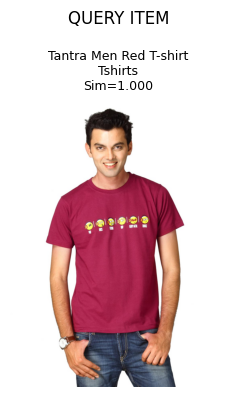

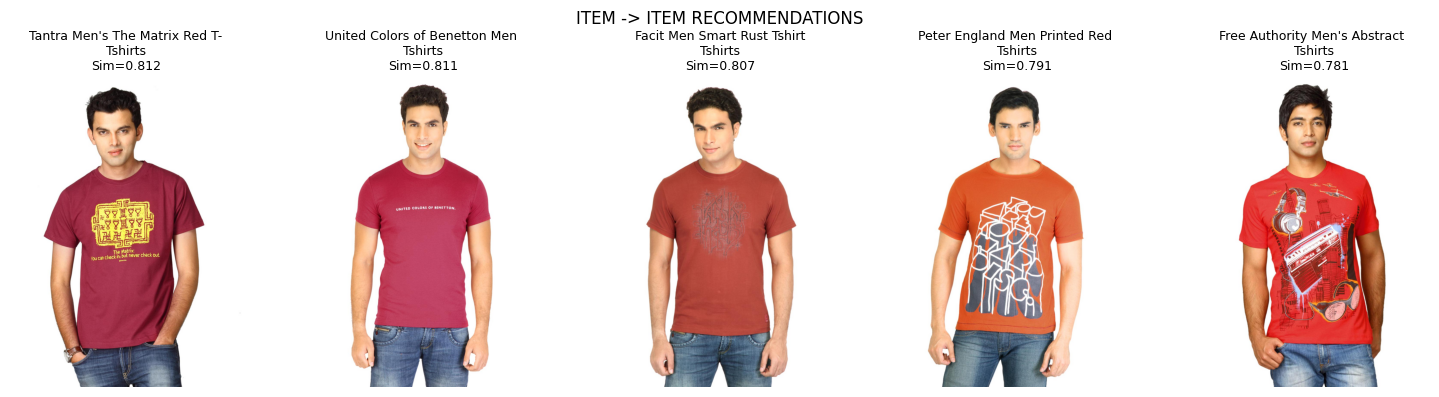

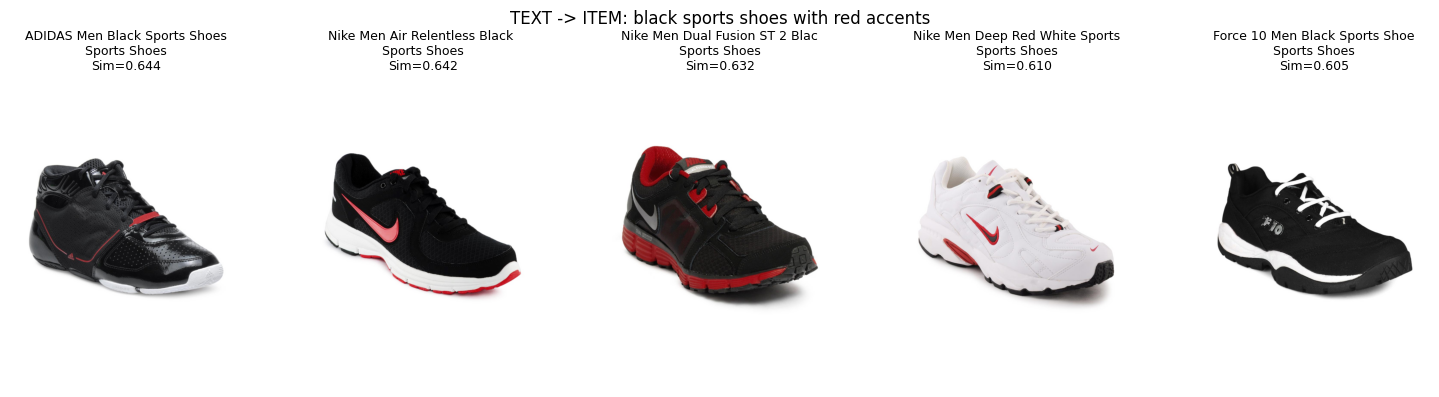

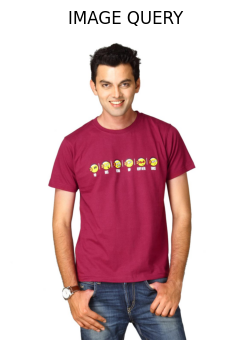

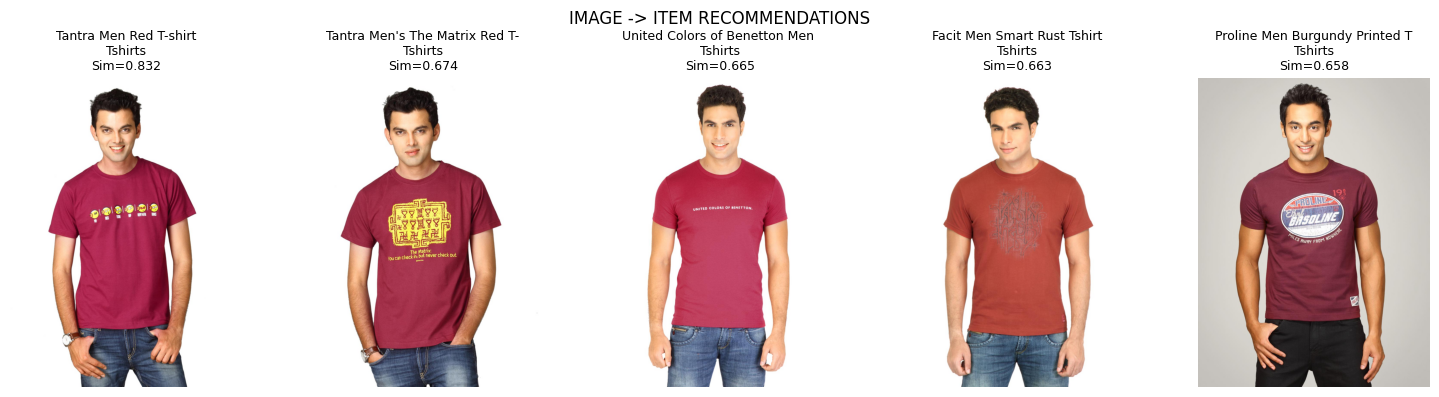

In [9]:
# để hiển thị đúng item trong test set, dùng dm.test_dataset.df
test_df = dm.test_dataset.df.reset_index(drop=True)

def show_recommendations(indices, scores, df_ref, data_dir, title):
    n = len(indices)
    plt.figure(figsize=(3*n, 4))
    for i, (idx, sc) in enumerate(zip(indices, scores)):
        plt.subplot(1, n, i+1)
        img_path = os.path.join(data_dir, df_ref.loc[idx, "image"])
        try:
            img = Image.open(img_path).convert("RGB")
            plt.imshow(img)
        except:
            plt.text(0.5, 0.5, "Image not found", ha="center", va="center")
        plt.axis("off")
        name = str(df_ref.loc[idx, "display_name"])[:30]
        cat = str(df_ref.loc[idx, "category"])
        plt.title(f"{name}\n{cat}\nSim={sc:.3f}", fontsize=9)
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

def recommend_by_item(query_idx, top_k=5):
    q = test_embs[query_idx].reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    sims[query_idx] = -np.inf
    top = np.argsort(sims)[-top_k:][::-1]
    return top, sims[top]

@torch.no_grad()
def text_embedding(text: str):
    # chỉ encode text query -> so với item_emb
    inputs = processor(
        text=text, images=None,
        return_tensors="pt", padding=True, truncation=True, max_length=config.clip_max_text_len
    )
    inputs = {k: v.to(config.device) for k, v in inputs.items() if k in ["input_ids", "attention_mask"]}
    txt_feat = model.clip.get_text_features(**inputs)
    txt_feat = F.normalize(txt_feat, p=2, dim=-1).cpu().numpy()[0]
    return txt_feat

def recommend_by_text(text: str, top_k=5):
    q = text_embedding(text).reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    top = np.argsort(sims)[-top_k:][::-1]
    return top, sims[top]

@torch.no_grad()
def image_embedding(image_pil: Image.Image):
    inputs = processor(images=image_pil, text=None, return_tensors="pt")
    pixel_values = inputs["pixel_values"].to(config.device)
    img_feat = model.clip.get_image_features(pixel_values=pixel_values)
    img_feat = F.normalize(img_feat, p=2, dim=-1).cpu().numpy()[0]
    return img_feat

def recommend_by_image(image_path: str, top_k=5):
    img = Image.open(image_path).convert("RGB")
    q = image_embedding(img).reshape(1, -1)
    sims = cosine_similarity(q, test_embs)[0]
    top = np.argsort(sims)[-top_k:][::-1]
    return img, top, sims[top]

# Demo 1: item -> item
query_idx = 0
top, sc = recommend_by_item(query_idx, top_k=5)
show_recommendations([query_idx], [1.0], test_df, config.data_dir, "QUERY ITEM")
show_recommendations(top, sc, test_df, config.data_dir, "ITEM -> ITEM RECOMMENDATIONS")

# Demo 2: text -> item
text_q = "black sports shoes with red accents"
top2, sc2 = recommend_by_text(text_q, top_k=5)
show_recommendations(top2, sc2, test_df, config.data_dir, f"TEXT -> ITEM: {text_q}")

# Demo 3: image -> item (đổi path ảnh bạn muốn query trong dataset)
# Ví dụ query bằng chính ảnh của item query_idx
img_query_path = os.path.join(config.data_dir, test_df.loc[query_idx, "image"])
img, top3, sc3 = recommend_by_image(img_query_path, top_k=5)
plt.figure(figsize=(4,4))
plt.imshow(img); plt.axis("off"); plt.title("IMAGE QUERY"); plt.show()
show_recommendations(top3, sc3, test_df, config.data_dir, "IMAGE -> ITEM RECOMMENDATIONS")


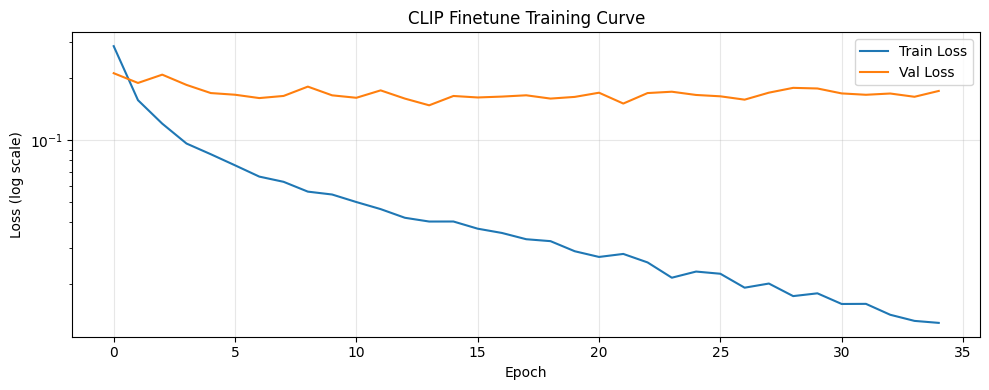

Saved plot: clip_training_curve.png


In [10]:
fig = plt.figure(figsize=(10,4))
plt.plot(trainer.train_losses, label="Train Loss")
plt.plot(trainer.val_losses, label="Val Loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss (log scale)")
plt.title("CLIP Finetune Training Curve")
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()

fig.savefig("clip_training_curve.png", dpi=200, bbox_inches="tight")
plt.show()

print("Saved plot: clip_training_curve.png")


In [11]:
# 1) save metrics
metrics_df = pd.DataFrame([metrics])
metrics_df.to_csv("clip_metrics.csv", index=False)
print("Saved: clip_metrics.csv")

# 2) save embeddings for later indexing (FAISS, etc.)
np.save("test_item_embeddings.npy", test_embs)
pd.Series(test_cats).to_csv("test_categories.csv", index=False)
print("Saved: test_item_embeddings.npy, test_categories.csv")

# 3) save a small report txt
with open("clip_run_summary.txt", "w", encoding="utf-8") as f:
    f.write("CLIP Finetune Multimodal Recommendation\n")
    f.write(f"Model: {config.clip_model_name}\n")
    f.write(f"Train/Val/Test: {len(dm.train_dataset)}/{len(dm.val_dataset)}/{len(dm.test_dataset)}\n")
    f.write(f"Batch size: {config.batch_size}\n")
    f.write(f"LR: {config.lr_clip}\n")
    f.write("Metrics:\n")
    for k,v in metrics.items():
        f.write(f"- {k}: {v}\n")
print("Saved: clip_run_summary.txt")

# 4) model checkpoint đã lưu ở CLIP_Finetune_best.pth
print("Best checkpoint:", best_ckpt)


Saved: clip_metrics.csv
Saved: test_item_embeddings.npy, test_categories.csv
Saved: clip_run_summary.txt
Best checkpoint: CLIP_Finetune_best.pth
